In [14]:
import pandas as pd
import os
import gc
import numpy as np
from tempfile import mkdtemp
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.fftpack import fft,ifft
from scipy import signal

In [15]:
def plt_plot(y_real,y_predict):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(len(y_real)),y_real, color='r')
    ax.plot(range(len(y_predict)),y_predict, color='b')
    plt.show()

In [18]:
def window1sDataCut(df_signal):
    if df_signal.shape[0]<1536000:#padding 0 when length less 1536000
        zero_data = np.zeros(shape=(1536000-df_signal.shape[0],4))
        df_temp = pd.DataFrame(zero_data, columns=df_signal.columns)
        df_raw_vibration=df_signal.append(df_temp)
    else:
        df_raw_vibration=df_signal
    df_raw_vibration_length = df_raw_vibration.shape[0]# cut head and tail when length more than 1536000
    delete_length = df_raw_vibration_length % 25600
    df_vibration = df_raw_vibration[delete_length//2 : (delete_length//2)+(25600*60)]
    print("after cut:",df_vibration.shape,60)
    return df_vibration,60

def load_train_fft_data(data_dire_list,sensor_channel="vibration_1"):
    train_data_pool_array=np.array([]).reshape(-1,60,12800)
    label_data_pool_array=np.array([]).reshape(-1,60,1)
    window=25600
    for data_dire in data_dire_list:
        file_dire=os.path.join(data_dire,'Sensor')
        file_list_length=len(os.listdir(file_dire))
        for file_index in range(1,file_list_length+1):
            residual_life_array=np.array([]).reshape(-1,60,1)
            fft_train_data_60s=np.array([]).reshape(-1,12800)
            df_signal=pd.read_csv(os.path.join(file_dire,str(file_index)+".csv"))
            df_60s,seconds_counts=window1sDataCut(df_signal)
            residual_life_array=np.append(residual_life_array,np.array([(file_list_length-file_index)*5]*seconds_counts).reshape(-1,60,1),axis=0)
            for _ in range(60):
                freqs=np.fft.fft(df_60s[sensor_channel][window*_:window*(_+1)])
                freqs=freqs[0:12800].reshape(-1,12800)
                fft_train_data_60s=np.append(fft_train_data_60s,freqs)
            train_data_pool_array=np.append(train_data_pool_array,fft_train_data_60s.reshape(-1,60,12800),axis=0)
            label_data_pool_array=np.append(label_data_pool_array,residual_life_array.reshape(-1,60,1),axis=0)
    source_filename = os.path.join(mkdtemp(), 'source.dat')
    source_data= np.memmap(source_filename, dtype='float32', mode='w+', shape=train_data_pool_array.shape)
    source_data = train_data_pool_array[:]

    label_filename = os.path.join(mkdtemp(), 'label.dat')
    label_data= np.memmap(label_filename, dtype='float32', mode='w+', shape=label_data_pool_array.shape)
    label_data = label_data_pool_array[:]
    return source_data,label_data
def load_test_fft_data(data_dire_list,tool_age_list,sensor_channel="vibration_1"):
    train_data_pool_array=np.array([]).reshape(-1,60,12800)
    label_data_pool_array=np.array([]).reshape(-1,60,1)
    window=12800
    for data_dire,index in zip(data_dire_list,range(len(data_dire_list))):
        file_dire=os.path.join(data_dire,'Sensor')
        file_list_length=len(os.listdir(file_dire))
        for file_index in range(1,file_list_length+1):
            residual_life_array=np.array([]).reshape(-1,60,1)
            fft_train_data_60s=np.array([]).reshape(-1,12800)
            df_signal=pd.read_csv(os.path.join(file_dire,str(file_index)+".csv"))
            df_60s,seconds_counts=window1sDataCut(df_signal)
            residual_life_array=np.append(residual_life_array,np.array([(file_list_length-file_index)*5+tool_age_list[index]]*seconds_counts).reshape(-1,60,1),axis=0)    
#             print(data_dire,str(file_index)+'.csv',(file_list_length-file_index)*5+tool_age_list[index])
            for _ in range(60):
                freqs=np.fft.fft(df_60s[sensor_channel][window*_:window*(_+1)])
                freqs=abs(freqs[0:12800].reshape(-1,12800))
                fft_train_data_60s=np.append(fft_train_data_60s,freqs)
            train_data_pool_array=np.append(train_data_pool_array,fft_train_data_60s.reshape(-1,60,12800),axis=0)
            label_data_pool_array=np.append(label_data_pool_array,residual_life_array.reshape(-1,60,1),axis=0)
    source_filename = os.path.join(mkdtemp(), 'test_source.dat')
    source_data= np.memmap(source_filename, dtype='float32', mode='w+', shape=train_data_pool_array.shape)
    source_data = train_data_pool_array[:]
    
    label_filename = os.path.join(mkdtemp(), 'test_label.dat')
    label_data= np.memmap(label_filename, dtype='float32', mode='w+', shape=label_data_pool_array.shape)
    label_data = label_data_pool_array[:]
    return source_data,label_data

In [17]:
def window1sDataCut(df_signal):
    if df_signal.shape[0]<1536000:#padding 0 when length less 1536000
        zero_data = np.zeros(shape=(1536000-df_signal.shape[0],4))
        df_temp = pd.DataFrame(zero_data, columns=df_signal.columns)
        df_raw_vibration=df_signal.append(df_temp)
    else:
        df_raw_vibration=df_signal
    
    df_raw_vibration_length = df_raw_vibration.shape[0]# cut head and tail when length more than 1536000
    delete_length = df_raw_vibration_length % 25600
    df_vibration = df_raw_vibration[delete_length//2 : (delete_length//2)+(25600*60)]
    print("after cut:",df_vibration.shape,60)
    return df_vibration,60
def load_train_data(data_dire_list):
    train_data_pool_array=np.array([]).reshape(-1,60,25600)
    label_data_pool_array=np.array([]).reshape(-1,60,1)
    for data_dire in data_dire_list:
        file_dire=os.path.join(data_dire,'Sensor')
        file_list_length=len(os.listdir(file_dire))
        for file_index in range(1,file_list_length+1):
            residual_life_array=np.array([]).reshape(-1,60,1)
            df_signal=pd.read_csv(os.path.join(file_dire,str(file_index)+".csv"))
            df_60s,seconds_counts=window1sDataCut(df_signal)
            residual_life_array=np.append(residual_life_array,np.array([(file_list_length-file_index)*5]*seconds_counts).reshape(-1,60,1),axis=0)    
            train_data_pool_array=np.append(train_data_pool_array,df_60s['vibration_1'].values.reshape(-1,60,25600),axis=0)
            label_data_pool_array=np.append(label_data_pool_array,residual_life_array.reshape(-1,60,1),axis=0)
    source_filename = os.path.join(mkdtemp(), 'source.dat')
    source_data= np.memmap(source_filename, dtype='float32', mode='w+', shape=train_data_pool_array.shape)
    source_data = train_data_pool_array[:]
    
    label_filename = os.path.join(mkdtemp(), 'label.dat')
    label_data= np.memmap(label_filename, dtype='float32', mode='w+', shape=label_data_pool_array.shape)
    label_data = label_data_pool_array[:]
    return source_data,label_data
def load_test_data(data_dire_list,tool_age_list):
    train_data_pool_array=np.array([]).reshape(-1,60,25600)
    label_data_pool_array=np.array([]).reshape(-1,60,1)
    for data_dire,index in zip(data_dire_list,range(len(data_dire_list))):
        file_dire=os.path.join(data_dire,'Sensor')
        file_list_length=len(os.listdir(file_dire))
        for file_index in range(1,file_list_length+1):
            residual_life_array=np.array([]).reshape(-1,60,1)
            df_signal=pd.read_csv(os.path.join(file_dire,str(file_index)+".csv"))
            df_60s,seconds_counts=window1sDataCut(df_signal)
            residual_life_array=np.append(residual_life_array,np.array([(file_list_length-file_index)*5+tool_age_list[index]]*seconds_counts).reshape(-1,60,1),axis=0)    
            train_data_pool_array=np.append(train_data_pool_array,df_60s['vibration_1'].values.reshape(-1,60,25600),axis=0)
            label_data_pool_array=np.append(label_data_pool_array,residual_life_array.reshape(-1,60,1),axis=0)
    source_filename = os.path.join(mkdtemp(), 'test_source.dat')
    source_data= np.memmap(source_filename, dtype='float32', mode='w+', shape=train_data_pool_array.shape)
    source_data = train_data_pool_array[:]
    
    label_filename = os.path.join(mkdtemp(), 'test_label.dat')
    label_data= np.memmap(label_filename, dtype='float32', mode='w+', shape=label_data_pool_array.shape)
    label_data = label_data_pool_array[:]
    return source_data,label_data

In [19]:
source_dire = "../../01-TrainingData-additional/"
source_dire_list=[
    "../../01-TrainingData-additional/01/",
    "../../01-TrainingData-additional/02/",
  "../../01-TrainingData-additional/03/"
]
test_dire = "../../02-TestingData-keD1/"
test_dire_list=[
    "../../02-TestingData-keD1/01/",
    "../../02-TestingData-keD1/02/",
  "../../02-TestingData-keD1/03/",
    "../../02-TestingData-keD1/04/",
    "../../02-TestingData-keD1/05/"
]
tool_age_list=[104,52,190,66,40]


In [20]:
train_data,train_label=load_train_data(source_dire_list)
valid_data,valid_label=load_test_data(test_dire_list,tool_age_list)

# train_fft_data,train_label=load_train_fft_data(source_dire_list)
# valid_fft_data,valid_label=load_test_fft_data(test_dire_list,tool_age_list)
gc.collect()

after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
after cut: (1536000, 4) 60
a

4181

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras import models as M
from keras import layers as L
from keras import metrics
from keras import optimizers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [22]:
def evaluation_metric(y_true, y_pred):
    y_true, y_pred = tf.reshape(y_true, [-1]), tf.reshape(y_pred, [-1])
    er = y_true - y_pred
    mask_n, mask_p = (er<=0), (er>0)
    er_n, er_p = tf.boolean_mask(er, mask_n), tf.boolean_mask(er, mask_p)
    score_n = tf.exp(-tf.log(0.5)*er_n/5)
    score_p = tf.exp(tf.log(0.5)*er_p/20)
    score = tf.concat([score_n, score_p], 0)
    score = tf.reduce_mean(score)*100
    return score
def cust_loss1(y_real,y_predicted):
    y_diff = y_real - y_predicted
    loss = tf.where(tf.greater(y_diff, 0),
                    -tf.exp(tf.log(0.5) * (y_diff / 20)) +1,
                    -tf.exp(-tf.log(0.5) * (y_diff / 5)) +1)
    return loss*tf.reduce_max(abs(y_diff))
def cust_loss2(y_real,y_predicted):
    y_diff = y_real - y_predicted
    loss = tf.where(tf.greater(y_diff, 0),
                    -tf.log(0.5) * (y_diff / 20),
                    tf.log(0.5) * (y_diff / 5))
    return loss**2
def Error_compute(y_real,y_predicted):
    y_diff=y_real-y_predicted
    diff_positive=y_diff[y_diff>0]
    diff_negitive_0=y_diff[y_diff<=0]
    if diff_negitive_0.shape[0] >0:
        sum_negitive_error=sum(np.exp(-np.log(0.5)*(diff_negitive_0/5)))
    else:
        sum_negitive_error=0
    if diff_positive.shape[0] >0:
        sum_positive_error=sum(np.exp(np.log(0.5)*(diff_positive/20)))
    else:
        sum_positive_error=0
    return (sum_negitive_error+sum_positive_error)/len(y_real)

In [23]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
graph = None
model = None

In [24]:
def LSTM_model(input_shape):
    x_input = L.Input(shape=input_shape)
    x=L.LSTM(units=300,activation="tanh",return_sequences=True)(x_input)#320
    x=L.TimeDistributed(L.Dense(150))(x)
    x=L.Dropout(0.5)(x)
    x=L.LSTM(units=60,activation="tanh",return_sequences=True)(x)
    y=L.TimeDistributed(L.Dense(1))(x)
    
    model = M.Model(inputs=x_input, outputs=y, name="LSTM")
    return model

In [13]:
checkpoint = ModelCheckpoint(filepath="./lstm_raw_fft.h5",monitor='val_evaluation_metric',verbose=1,save_best_only='True',
                             mode='max',period=1)
# tensorboard = TensorBoard(log_dir='log(./)')
callback_lists = [checkpoint]  #因为callback是list型,必须转化为list
graph = tf.get_default_graph()
model=LSTM_model((60,12800))
model.summary()
# model=LSTM_model((60,12800))
Adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer=Adam,metrics=[evaluation_metric])
# model.compile(loss=cust_loss2, optimizer=Adam,metrics=[evaluation_metric])
model.fit(train_fft_data,train_label, epochs=1000, verbose=2,batch_size=25,
          validation_data=(valid_fft_data, valid_label),callbacks=callback_lists)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 12800)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 300)           15721200  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 5)             1505      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 5)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 60)            15840     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 60, 1)             61        
Total params: 15,738,606
Trainable params: 15,738,606
Non-trainable params: 0
________________________________________________________________

In [25]:
checkpoint = ModelCheckpoint(filepath="./lstm_raw.h5",monitor='val_evaluation_metric',verbose=1,save_best_only='True',
                             mode='max',period=1)
# tensorboard = TensorBoard(log_dir='log(./)')
callback_lists = [checkpoint]  #因为callback是list型,必须转化为list
graph = tf.get_default_graph()
model=LSTM_model((60,25600))
model.summary()
Adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer=Adam,metrics=[evaluation_metric])
# model.compile(loss=cust_loss2, optimizer=Adam,metrics=[evaluation_metric])
model.fit(train_data,train_label, epochs=2000, verbose=2,batch_size=25,validation_data=(valid_data, valid_label),callbacks=callback_lists)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 25600)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 300)           31081200  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 150)           45150     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 150)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 60)            50640     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 60, 1)             61        
Total params: 31,177,051
Trainable params: 31,177,051
Non-trainable params: 0
________________________________________________________________

KeyboardInterrupt: 

In [26]:
from keras.models import load_model
# model = load_model('lstm_raw_fft.h5',{"evaluation_metric":evaluation_metric})
model = load_model('lstm_raw.h5',{"evaluation_metric":evaluation_metric})

In [27]:
# predicted=model.predict(train_fft_data).reshape(-1,)
predicted=model.predict(train_data).reshape(-1,)

0.150156789537


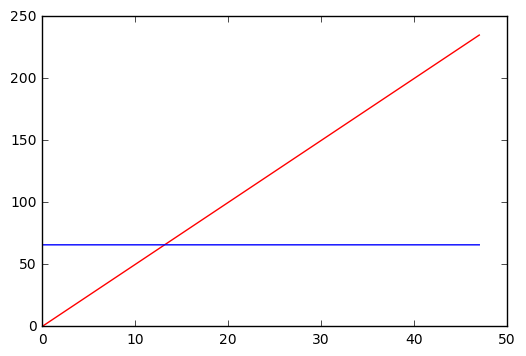

In [28]:
df_result=pd.DataFrame({"real":train_label.reshape(-1,),"predicted":predicted})
df_predict=df_result["predicted"].groupby(df_result['real']).mean()
err=Error_compute(df_predict.index,df_predict)
print(err)
plt_plot(df_predict.index,df_predict)

0.326715789601


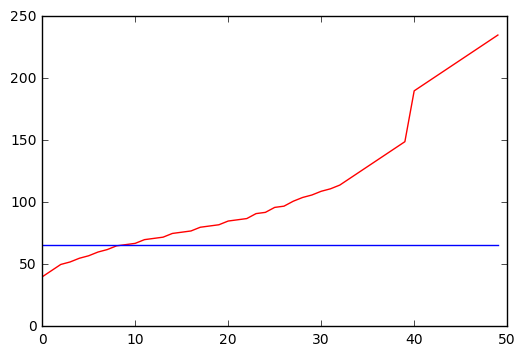

In [29]:
predicted=model.predict(valid_data).reshape(-1,)
df_result=pd.DataFrame({"real":valid_label.reshape(-1,),"predicted":predicted})
df_predict=df_result["predicted"].groupby(df_result['real']).mean()
err=Error_compute(df_predict.index,df_predict)
print(err)
plt_plot(df_predict.index,df_predict)

In [ ]:
a=data_generator(train_data_list_pool,label_data_list_pool,source_dire_list,batch_size=5,time_range=1)
i=1
for data ,label in a:
    print(data.shape,label.shape)
    print(i)
    i=i+1

In [17]:
def window1sDataCut(df_signal):
    if df_signal.shape[0]<1536000:#padding 0 when length less 1536000
        zero_data = np.zeros(shape=(1536000-df_signal.shape[0],4))
        df_temp = pd.DataFrame(zero_data, columns=df_signal.columns)
        df_raw_vibration=df_signal.append(df_temp)
    else:
        df_raw_vibration=df_signal
    
    df_raw_vibration_length = df_raw_vibration.shape[0]# cut head and tail when length more than 1536000
    delete_length = df_raw_vibration_length % 25600
    df_vibration = df_raw_vibration[delete_length//2 : (delete_length//2)+(25600*60)]
    print("after cut:",df_vibration.shape,60)
    return df_vibration.values,60
def get_train_data_list_pool(data_dire_list):#获得多个文件夹中的源数据
    train_data_list_pool=[]
    label_data_list_pool=[]# source data from mutiply floder 
    for data_dire in data_dire_list:
        file_dire=os.path.join(data_dire,'Sensor')
        file_list_length=len(os.listdir(file_dire))
        train_data_pool_list=[]
        label_data_pool_list=[]
        for file_index in range(1,file_list_length+1):
            residual_life_list=[]
            df_signal=pd.read_csv(os.path.join(file_dire,str(file_index)+".csv"))
            df_60s,seconds_counts=window1sDataCut(df_signal)
            residual_life_list.extend([(file_list_length-file_index)*5]*seconds_counts)
            label_data_pool_list.append(residual_life_list)
            train_data_pool_list.append(df_60s)
        train_data_list_pool.append(train_data_pool_list)
        label_data_list_pool.append(label_data_pool_list)
    return train_data_list_pool,label_data_list_pool

def data_generator(train_data_list_pool,label_data_list_pool,data_dire_list,batch_size=5,time_range=1):
#     train_data_list_pool,label_data_list_pool=get_train_data_list_pool(data_dire_list)
    
    file_list_length=0#获得一个epoch中每个batch需要输出的所有随机样本序列号
    for train_data_list in train_data_list_pool:
        file_list_length=file_list_length+len(train_data_list)-time_range
    batch_random_list_epoch=list(range(1,(file_list_length+1)))
    np.random.shuffle(batch_random_list_epoch)
    exit()
    for i in range((file_list_length)//batch_size):
        train_data=np.array([]).reshape(-1,60*time_range,25600)
#         label_data=np.array([]).reshape(-1,60*time_range,1)
        label_data=np.array([]).reshape(-1,60*time_range,1)
        batch_random_list=batch_random_list_epoch[batch_size*i:batch_size*(i+1)]#某batch需要输出的样本序列号
        for start_index in batch_random_list:
            signal_array=np.array([]).reshape(-1,25600)
            residual_life_list=[]
            
            upper_bound_file_num=0                               #确定从第几个文件夹中获取数据
            lower_bound_file_num=0
            for floder_index in range(len(train_data_list_pool)):
                upper_bound_file_num=upper_bound_file_num+len(train_data_list_pool[floder_index])-time_range
                if start_index<=upper_bound_file_num:
                    for minute_index in range(start_index,start_index+time_range):#将time_range分钟的数据连接在一起
#                         print("floder_index,file_index",floder_index,minute_index-lower_bound_file_num)
                        df_60s=train_data_list_pool[floder_index][minute_index-1-lower_bound_file_num]
                        reshape_data = df_60s['vibration_1'].values.reshape(-1, 25600)
                        signal_array = np.append(signal_array,reshape_data,axis=0)
                        residual_life_list.extend(label_data_list_pool[floder_index][minute_index-1-lower_bound_file_num])
                    break
                lower_bound_file_num=lower_bound_file_num+len(train_data_list_pool[floder_index])-time_range
                
            resudual_life_array = np.array(residual_life_list)#把上一步中得到的time_range分钟数据作为一条样本加到一个batch组中
            signal_array=signal_array.reshape(-1,60*time_range,25600)
            resudual_life_array=resudual_life_array.reshape(-1,60*time_range,1)
            train_data=np.append(train_data,signal_array,axis=0)
            label_data=np.append(label_data,resudual_life_array,axis=0)
            label_data=label_data.reshape(-1,60,)
            gc.collect()
            yield train_data,label_data
#         for data,label in zip(train_data,label_data):
#             yield data,label

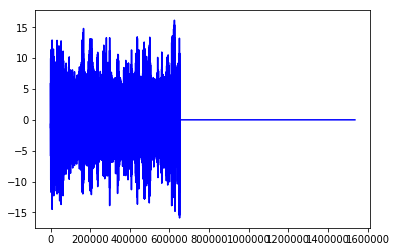

In [60]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(len(df_signal["vibration_1"])),df_signal["vibration_1"], color='b')
plt.show()

In [59]:
file_dire=os.path.join(source_dire,'0'+str(1),'Sensor')
file_list_length=len(os.listdir(file_dire))
for file_index in range(1,file_list_length+1):
    df_signal=pd.read_csv(os.path.join(file_dire,str(file_index)+".csv"))
    print(file_index,df_signal.shape)

df_signal=pd.read_csv(os.path.join(file_dire,str(13)+".csv"))
if df_signal.shape[0]<1536000:
    zero_data = np.zeros(shape=(1536000-df_signal.shape[0],4))
    df_temp = pd.DataFrame(zero_data, columns=df_signal.columns)
df_signal=df_signal.append(df_temp)

In [3]:
def sequence_data_generator(data_dire,batch_size=5,time_range=1,dire_index=1):
    file_dire=os.path.join(data_dire,'0'+str(dire_index),'Sensor')
    file_list_length=len(os.listdir(file_dire))
    batch_random_list_epoch=list(range(1,file_list_length+1-time_range))
    np.random.shuffle(batch_random_list_epoch)
    for i in range((file_list_length+1-time_range)//batch_size):
        train_data=np.array([]).reshape(-1,60*time_range,25600)
        label_data=np.array([]).reshape(-1,60*time_range,1)
        batch_random_list=batch_random_list_epoch[batch_size*i:batch_size*(i+1)]
        for start_index in batch_random_list:
            signal_array=np.array([]).reshape(-1,25600)
            residual_life_list=[]
            for file_index in range(start_index,start_index+time_range):
                df_signal=pd.read_csv(os.path.join(file_dire,str(file_index)+".csv"))
                df_60s,seconds_counts=window1sDataCut(df_signal)
                reshape_data = df_60s['vibration_1'].values.reshape(-1, 25600)
                signal_array = np.append(signal_array,reshape_data,axis=0)
                residual_life_list.extend([(file_list_length-file_index)*5]*seconds_counts)
            resudual_life_array = np.array(residual_life_list)
            gc.collect()
            signal_array=signal_array.reshape(-1,60*time_range,25600)
            resudual_life_array=resudual_life_array.reshape(-1,60*time_range,1)
            train_data=np.append(train_data,signal_array,axis=0)
            label_data=np.append(label_data,resudual_life_array,axis=0)
        yield train_data,label_data 


In [3]:
def window1sDataCut(df_signal):
    if df_signal.shape[0]<1536000:#padding 0 when length less 1536000
        zero_data = np.zeros(shape=(1536000-df_signal.shape[0],4))
        df_temp = pd.DataFrame(zero_data, columns=df_signal.columns)
        df_raw_vibration=df_signal.append(df_temp)
    else:
        df_raw_vibration=df_signal
    
    df_raw_vibration_length = df_raw_vibration.shape[0]# cut head and tail when length more than 1536000
    delete_length = df_raw_vibration_length % 25600
    df_vibration = df_raw_vibration[delete_length//2 : (delete_length//2)+(25600*60)]
    print("after cut:",df_vibration.shape,60)
    return df_vibration,60
def get_train_data_pool(data_dire,dire_index=1):
    file_dire=os.path.join(data_dire,'0'+str(dire_index),'Sensor')
    file_list_length=len(os.listdir(file_dire))
    train_data_pool_list=[]
    label_data_pool_list=[]
    for file_index in range(1,file_list_length+1):
        residual_life_list=[]
        df_signal=pd.read_csv(os.path.join(file_dire,str(file_index)+".csv"))
        df_60s,seconds_counts=window1sDataCut(df_signal)
        residual_life_list.extend([(file_list_length-file_index)*5]*seconds_counts)
        label_data_pool_list.append(residual_life_list)
        train_data_pool_list.append(df_60s)
    return train_data_pool_list,label_data_pool_list    
def sequence_data_generator_load_memary(data_dire,batch_size=5,time_range=1,dire_index=1):
    train_data_pool_list,label_data_pool_list=get_train_data_pool(data_dire)
    file_list_length=len(train_data_pool_list)
    batch_random_list_epoch=list(range(1,file_list_length+1-time_range))
    np.random.shuffle(batch_random_list_epoch)
    for i in range((file_list_length+1-time_range)//batch_size):
        train_data=np.array([]).reshape(-1,60*time_range,25600)
        label_data=np.array([]).reshape(-1,60*time_range,1)
        batch_random_list=batch_random_list_epoch[batch_size*i:batch_size*(i+1)]

        for start_index in batch_random_list:
            signal_array=np.array([]).reshape(-1,25600)
            residual_life_list=[]
            for file_index in range(start_index,start_index+time_range):
                df_60s=train_data_pool_list[file_index-1]
                reshape_data = df_60s['vibration_1'].values.reshape(-1, 25600)
                signal_array = np.append(signal_array,reshape_data,axis=0)
                residual_life_list.extend(label_data_pool_list[file_index-1])
            resudual_life_array = np.array(residual_life_list)
            signal_array=signal_array.reshape(-1,60*time_range,25600)
            resudual_life_array=resudual_life_array.reshape(-1,60*time_range,1)
            train_data=np.append(train_data,signal_array,axis=0)
            label_data=np.append(label_data,resudual_life_array,axis=0)
            gc.collect()
        yield train_data,label_data     